In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip 'drive/My Drive/Project Final-Online Abuse/Dataset'

Archive:  drive/My Drive/Project Final-Online Abuse/Dataset.zip
  inflating: test.csv                
  inflating: train.csv               


# Files imported

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Pre-processing
import nltk
# to remove stopwords
from nltk.corpus import stopwords
# to stem the words
from nltk.stem.snowball import SnowballStemmer
# for regular expressions
import re

# Predicting
# to create bag-of-words and tfidf vectoriser
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# to split into training and validation sets to avoid over-fitting
from sklearn.model_selection import cross_val_score

# ML algorithms
# naive bayes
from sklearn.naive_bayes import MultinomialNB
# svm
from sklearn import svm
# logistic regression
from sklearn.linear_model import LogisticRegression

# Neural network
# to create neural network model
from keras.models import Sequential
# for different kinds of layer
from keras.layers import Dense,Flatten,Dropout,MaxPooling1D,Conv1D
# to create word embeddings
from keras.layers.embeddings import Embedding
# to tokenize comments for input to neural network
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
# to pad comments
from keras.preprocessing.sequence import pad_sequences

#For wordcloud
from wordcloud import WordCloud

Using TensorFlow backend.


In [0]:
nltk.download('all')

In [0]:
#reading the train ans test files
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [0]:
#train file size
data.shape

(159571, 8)

In [0]:
#test file size
test.shape

(153164, 2)

## Opening file in pandas DataFrame.

In [0]:
# Training data file.
#data=data.iloc[0:100000,:]

#dropping 'id' column
data.drop('id',axis=1,inplace=True)

In [0]:
# adding a 'clean' column for marking clean comments
data['clean']=0
Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
data['clean'] = 1-data[Col].max(axis=1)

In [0]:
# Testing data file.
#test=test.iloc[0:50000,:]

#dropping 'id' columns
test.drop('id',axis=1,inplace=True)

In [0]:
# train file
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


## Preprocessing

**Removing non-alphanumeric symbols like \n, punctuations and numbers.**

In [0]:
# Removes non-alphanumeric symbols like \n, punctuations.

def strip(text):
    return ' '.join(re.compile(r'[^a-zA-Z]').split(text)) 

# W+ matches any non-alphanumeric char
# re.compile() converts string to regular expression object
# .split(text) splits 

**Stop-words are words that occur frequently but carry negligible information. Example:'I','are','you',etc.**

**Below is the function to remove stop-words from the comments.**

In [0]:
# Function to remove stopwords from comments

def stop(comment):
  
    stop_comment=[]
    
    # Removing the stopwords
    for word in comment.split(' '):
        if word not in stopwords.words('english'):
          #converting to lowercase
            stop_comment.append(word.lower())
            
    return ' '.join(stop_comment)

**The process of stemming of words is to reduce them to their root. Example:Stem word of 'listing' is 'list' and of 'commited' is 'commit'.**

**Below is the function to stem the comments.**

In [0]:
# Function to stem the comments

def stem(text):
  
    text = text.split()
    #using SnowballStemmer
    stemmer = SnowballStemmer('english')
    
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

**Applying preprocessing to training data.**

In [0]:
# Creating new columns which contains comments without non-alphanumeric char
data['comment-stop']=data['comment_text'].apply(strip)

# Removing short words: I have chosen to remove words with length less than 3 letters
data['comment-stop']=data['comment-stop'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Removing stop words
data['comment-stop']=data['comment-stop'].apply(stop)

# Stemming comments
data['comment-stem']=data['comment-stop'].apply(stem)


**Applying preprocessing to the testing data.**

In [0]:
# Creating new columns which contains comments without non-alphanumeric char
test['comment-stop']=test['comment_text'].apply(strip)

# Removing short words
test['comment-stop']=test['comment-stop'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Removing stop words
test['comment-stop']=test['comment-stop'].apply(stop)

# Stemming comments
test['comment-stem']=test['comment-stop'].apply(stem)


## **Comparing number of unique words in unclean, clean and stemmed comments.**

In [0]:
# We will be using CountVectorizer to count the number of unique words comments corpus.

count_vectorizer=CountVectorizer()

#load unclean comments
x_unclean=data['comment_text']

count_vectorizer_vectors=count_vectorizer.fit_transform(x_unclean)
print('Unique words in unclean comments corpus : ',count_vectorizer_vectors.shape) # rows X words

#load clean comments
x_stop=data['comment-stop']

count_vectorizer_vectors=count_vectorizer.fit_transform(x_stop)
print('Unique words in cleaned comments with no stop words : ',count_vectorizer_vectors.shape)

#load stemmed comments
x_stem=data['comment-stem']

count_vectorizer_vectors=count_vectorizer.fit_transform(x_stem)
print('Unique words in cleaned comments with stemmed words : ',count_vectorizer_vectors.shape)

Unique words in unclean comments corpus :  (159571, 189775)
Unique words in cleaned comments with no stop words :  (159571, 161798)
Unique words in cleaned comments with stemmed words :  (159571, 126495)


**We can see from above results that cleaning and stemming the comments helps in reducing the number of unique words. The fewer the words, the faster the processing!**

**Not all words in the corpus are equally relevant.**

**Words that have fewer occurance in comments would carry more information than other words.**

**With the help of Tf we can determine how frequently a word occurs in comments (Term frequency). Then using Idf (Inverted document frequency) we can determine how useful a word is in the whole corpus.** 

In [0]:
 #Tf-idf
x_stem=data['comment-stem']

tfidf_vectorizer=TfidfVectorizer()

#fit_transform tfidf vectorizer on x_stem comments
tfidf_vectorizer_train=tfidf_vectorizer.fit_transform(x_stem)

In [0]:
#words and their feature indices
count=0
for word,index in tfidf_vectorizer.vocabulary_.items():
  print(word,index)
  count+=1
  if count>10:
    break

explan 36549
edit 32795
made 65767
usernam 117221
hardcor 46971
metallica 69753
revert 93029
they 110882
vandal 117787
closur 21165
vote 119655


In [0]:
tfidf_vectorizer.idf_[:10]

array([11.59395615, 11.88163822, 12.28710333, 12.28710333, 11.88163822,
       12.28710333, 12.28710333, 12.28710333, 12.28710333, 12.28710333])

**We can write unique stemmed words to a csv file.**

In [0]:
# words=transform_stem
# #words.columns=list_of_words

# df_word=pd.DataFrame(words.todense())
# df_word.columns=vector_stem.get_feature_names() # assigning column name based on the corresponding word

# df_word.to_csv('Words.csv',index=False)
# #df_word # Dataframe column contains word in sparse vector.

## Predicting on stemmed comments.

In [0]:
#create a list of all the categories
Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate","clean"]

### Logistic Regression

In [0]:
lr=LogisticRegression()
    
for target in Col:
  
    #Using cross-validation with 3 folds.
    
    score_tf=cross_val_score(lr,tfidf_vectorizer_train,data[target],cv=3,verbose=0,n_jobs=-1)
    
    print(target,':',score_tf.mean())

toxic : 0.9259001741068352
severe_toxic : 0.989999959191835
obscene : 0.9626998369833837
threat : 0.9966999999340066
insult : 0.9585998166513156
identity_hate : 0.9915999998320167
clean : 0.9212997784481507


In [0]:
rand=random.randint(0,len(test))
sent=test['comment-stem'][rand]

print(sent)
for target in Col:
    lr.fit(tfidf_vectorizer_train,data[target])
    print(target,':',lr.predict(tfidf_vectorizer.transform([sent])))

pleas someon imag back wikipedia encyclopedia pulpit advoc virtu free media wrong perhap time someon start encyclopedia
toxic : [0]
severe_toxic : [0]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


obscene : [0]
threat : [0]
insult : [0]
identity_hate : [0]
clean : [1]


### Naive Bayes

In [0]:
naive=MultinomialNB()

    
for target in Col:
  
    #Using cross-validation with 3 folds.
    
    score_tf=cross_val_score(naive,tfidf_vectorizer_train,data[target],cv=3,verbose=0,n_jobs=-1)
    
    print(target,':',score_tf.mean())

toxic : 0.9190399979838281
severe_toxic : 0.9899399998979891
obscene : 0.9517799935612952
threat : 0.9968199999974559
insult : 0.9517400039614712
identity_hate : 0.9913899999931118
clean : 0.9162600013832382


In [0]:
rand=random.randint(0,len(test))
sent=test['comment-stem'][rand]

print(sent)
for target in Col:
    naive.fit(tfidf_vectorizer_train,data[target])
    print(target,':',naive.predict(tfidf_vectorizer.transform([sent])))

fuck anti semit cunt
toxic : [1]
severe_toxic : [0]
obscene : [0]
threat : [0]
insult : [0]
identity_hate : [0]
clean : [0]


### SVM

In [0]:
# Using best result for hyperparamter from gridsearchCV.

svc=svm.SVC(kernel='linear',C=3,random_state=27)

for target in Col:
  
    #Using cross-validation with 3 folds.
    
    score_tf=cross_val_score(svc,tfidf_vectorizer_train,data[target],cv=3,verbose=0,n_jobs=-1)
    
    print(target,':',score_tf.mean())

toxic : 0.9565146538547253
severe_toxic : 0.9900984544546727


In [0]:
# Now let's test the algorithm on a random comment from test set.
rand=random.randint(0,len(test))
sent=test['comment-stem'][rand]

print(sent)
for target in Col:
    svc.fit(tfidf_vectorizer_train,data[target])
    print(target,':',svc.predict(tfidf_vectorizer.transform([sent])))

adic valuat must integ
toxic : [0]
severe_toxic : [0]
obscene : [0]
threat : [0]
insult : [0]
identity_hate : [0]
clean : [1]


## Neural Network

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data[list_classes].values

In [0]:
# Creating object of Keras Tokeniser().
tokenizer=Tokenizer()

# map words in vocabulary to unique integers
x_stem=data['comment-stem']
tokenizer.fit_on_texts(x_stem)

# splits comments into a list of words replaced by their index 
sequence=tokenizer.texts_to_sequences(x_stem)

In [0]:
#words replaced by their indices for first comment
sequence[0]

[469,
 4,
 60,
 507,
 3082,
 7152,
 56,
 215,
 53,
 4197,
 418,
 955,
 6960,
 7,
 23,
 188,
 5,
 2,
 70,
 1618]

In [0]:
# Words with higher frequency will get lower index
# this can also be viewed in the wordcloud
count=0
for word,index in tokenizer.word_index.items():
  print(word,index)
  count+=1
  if count>10:
    break

articl 1
page 2
wikipedia 3
edit 4
talk 5
like 6
pleas 7
would 8
delet 9
thank 10
sourc 11


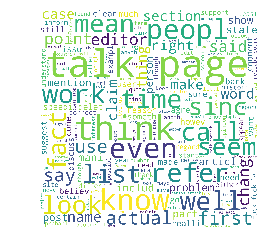

In [0]:
# Creating a wordcloud in which words are displayed in different sizes depending on their frequency 
# of occurence in the complete corpus.
cloud=WordCloud(background_color='white',width=2000,height=2000).generate(' '.join(x_stem))
plt.axis('off')
plt.imshow(cloud);

In [0]:
total_words=len(tokenizer.word_index)
print('Total unique words:',total_words) # total unique words
# ** total unique words will go as input to embedding layer **

length_comment=[]
comment=x_stem

# Finding the maximum length comment.
for row in comment:
    length_comment.append(len(row.split(' ')))
max_length_comment=max(length_comment)
print('Max length comment:',max_length_comment) # max length of comment

Total unique words: 126498
Max length comment: 1000


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#checkpoint
checkpoint=ModelCheckpoint(filepath='test.best.weights.hdf5',verbose=1,save_best_only=True)
#early sotpping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1)

In [0]:
#maximum length comment value required for comment padding
maxlen = max_length_comment

#padding the comments to maximum comment length so that all comment are of same length
#smaller comments will have 0 in place of absent words
pad_doc = pad_sequences(sequence, maxlen=maxlen)


model=Sequential()

#embedding layer
model.add(Embedding(input_dim=total_words+1, output_dim=100,input_length=maxlen))
# input_dim : Size of the vocabulary, i.e. maximum integer index + 1.
# output_dim : Dimension of the dense embedding.
# put_length : Length of input sequences.

model.add(Conv1D(filters=60,kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv1D(filters=40,kernel_size=2,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) 

model.add(Conv1D(filters=35,kernel_size=2,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) 

model.add(Flatten())
model.add(Dense(6,activation='softmax'))          

#model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         12649900  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 998, 60)           18060     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 499, 60)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 499, 60)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 498, 40)           4840      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 249, 40)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 249, 40)           0         
__________

**We can see that Embedding layer takes comments of length maxlen as input and has an output of 100 dimensions.**

In [0]:
history=model.fit(pad_doc,y, batch_size=32, epochs=10, validation_split=0.4,callbacks=[es,checkpoint])

Train on 95742 samples, validate on 63829 samples
Epoch 1/10
95742/95742 [==============================] - 96s 999us/step - loss: 0.2267 - acc: 0.9636 - val_loss: 0.2242 - val_acc: 0.9640

Epoch 00001: val_loss did not improve from 0.08448
Epoch 2/10
95742/95742 [==============================] - 95s 989us/step - loss: 0.2235 - acc: 0.9647 - val_loss: 0.2236 - val_acc: 0.9658

Epoch 00002: val_loss did not improve from 0.08448
Epoch 3/10
95742/95742 [==============================] - 95s 989us/step - loss: 0.2216 - acc: 0.9660 - val_loss: 0.2237 - val_acc: 0.9651

Epoch 00003: val_loss did not improve from 0.08448
Epoch 00003: early stopping


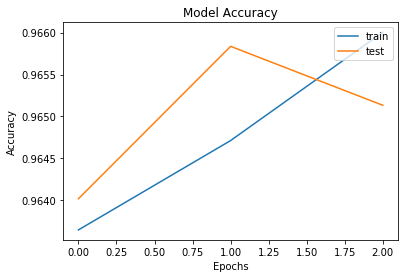

In [0]:
#plotting our result
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper right')
plt.show()

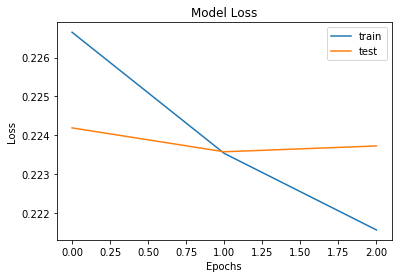

In [0]:
#plotting our result
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper right')
plt.show()

In [0]:
model.save('drive/My Drive/Project Final-Online Abuse/text.complete.best.weights.hdf5')

In [0]:
model.load_weights('drive/My Drive/Project Final-Online Abuse/text.complete.best.weights.hdf5')

In [0]:
#replace words in test comments by indices
test_sequence=tokenizer.texts_to_sequences(test['comment-stem'])
#pad the sequences
pad_test = pad_sequences(test_sequence, maxlen=maxlen)

In [0]:
#predict on test comments
prediction=model.predict(pad_test)

Now write the results to submission file.

In [0]:
submit=pd.read_csv('./test.csv')
submit.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [0]:
submit.drop('comment_text',inplace=True,axis=1)
submit.head()

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb


In [0]:
#
for i in range(len(prediction)):
  submit.loc[i,'toxic']=prediction[i][0]
  submit.loc[i,'severe_toxic']=prediction[i][1]
  submit.loc[i,'obscene']=prediction[i][2]
  submit.loc[i,'threat']=prediction[i][3]
  submit.loc[i,'insult']=prediction[i][4]
  submit.loc[i,'identity_hate']=prediction[i][5]

In [0]:
submit.to_csv('drive/My Drive/Project Final-Online Abuse/submit.csv',index=False)

In [0]:
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.349276,0.081702,0.225270,0.063192,0.201415,0.079144
1,0000247867823ef7,0.251608,0.127592,0.169160,0.141908,0.165436,0.144295
2,00013b17ad220c46,0.339168,0.094158,0.192268,0.077304,0.189897,0.107204
3,00017563c3f7919a,0.250084,0.128613,0.169116,0.144539,0.162174,0.145473
4,00017695ad8997eb,0.268110,0.121698,0.169766,0.136915,0.163935,0.139577
